**라이브러리 버전 확인**

In [ ]:
import xgboost
import lightgbm
import missingno
import sklearn

print(xgboost.__version__)
print(lightgbm.__version__)
print(missingno.__version__)
print(sklearn.__version__)

0.90
2.2.3
0.5.1
1.0.2


In [ ]:
import warnings
warnings.filterwarnings("ignore")  # 경고창 무시

import os
from os.path import join # 경로(패스)명 조작에 관한 처리를 모아둔 모듈로써 구현되어 있는 함수의 하나이다.
                         # 인수에 전달된 2개의 문자열을 결합하여, 1개의 경로로 할 수 있다.

import pandas as pd
import numpy as np

import missingno as msno

from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import KFold, cross_val_score
from sklearn.model_selection import train_test_split
import xgboost as xgboost
import lightgbm as lgb

import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
data_dir = '/content/drive/MyDrive/colab/data'

train_data_path = join(data_dir, 'train.csv')  # train 파일 경로 설정
test_data_path = join(data_dir, 'test.csv')    # test 파일 경로 설정

train = pd.read_csv(train_data_path)
test = pd.read_csv(test_data_path)

print(train_data_path)
print(test_data_path)

/content/drive/MyDrive/colab/data/train.csv
/content/drive/MyDrive/colab/data/test.csv


In [ ]:
train.head()  # train 데이터 확인

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,0,20141013T000000,221900.0,3,1.00,1180,5650,1.0,0,0,...,7,1180,0,1955,0,98178,47.5112,-122.257,1340,5650
1,1,20150225T000000,180000.0,2,1.00,770,10000,1.0,0,0,...,6,770,0,1933,0,98028,47.7379,-122.233,2720,8062
2,2,20150218T000000,510000.0,3,2.00,1680,8080,1.0,0,0,...,8,1680,0,1987,0,98074,47.6168,-122.045,1800,7503
3,3,20140627T000000,257500.0,3,2.25,1715,6819,2.0,0,0,...,7,1715,0,1995,0,98003,47.3097,-122.327,2238,6819
4,4,20150115T000000,291850.0,3,1.50,1060,9711,1.0,0,0,...,7,1060,0,1963,0,98198,47.4095,-122.315,1650,9711


In [ ]:
test.head()  # test 데이터 확인

,id,date,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,15035,20141209T000000,3,2.25,2570,7242,2.0,0,0,3,7,2170,400,1951,1991,98125,47.7210,-122.319,1690,7639
1,15036,20141209T000000,4,3.00,1960,5000,1.0,0,0,5,7,1050,910,1965,0,98136,47.5208,-122.393,1360,5000
2,15037,20140512T000000,4,4.50,5420,101930,1.0,0,0,3,11,3890,1530,2001,0,98053,47.6561,-122.005,4760,101930
3,15038,20150415T000000,3,1.00,1780,7470,1.0,0,0,3,7,1050,730,1960,0,98146,47.5123,-122.337,1780,8113
4,15039,20150312T000000,3,2.50,1890,6560,2.0,0,0,3,7,1890,0,2003,0,98038,47.3684,-122.031,2390,7570


In [ ]:
train['date'] = train['date'].apply(lambda i: i[:6]).astype(int)  # date 컬럼을 5번째까지 정수형 데이터로 전처리
train.head()  # date 열이 전처리된 것을 확인

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,0,201410,221900.0,3,1.00,1180,5650,1.0,0,0,...,7,1180,0,1955,0,98178,47.5112,-122.257,1340,5650
1,1,201502,180000.0,2,1.00,770,10000,1.0,0,0,...,6,770,0,1933,0,98028,47.7379,-122.233,2720,8062
2,2,201502,510000.0,3,2.00,1680,8080,1.0,0,0,...,8,1680,0,1987,0,98074,47.6168,-122.045,1800,7503
3,3,201406,257500.0,3,2.25,1715,6819,2.0,0,0,...,7,1715,0,1995,0,98003,47.3097,-122.327,2238,6819
4,4,201501,291850.0,3,1.50,1060,9711,1.0,0,0,...,7,1060,0,1963,0,98198,47.4095,-122.315,1650,9711


In [ ]:
y = train['price']  # 변수 y에 price 컬럼 넣기
del train['price']  # train에서 price 컬럼 삭제 

print(train.columns)

Index(['id', 'date', 'bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot',
       'floors', 'waterfront', 'view', 'condition', 'grade', 'sqft_above',
       'sqft_basement', 'yr_built', 'yr_renovated', 'zipcode', 'lat', 'long',
       'sqft_living15', 'sqft_lot15'],
      dtype='object')


In [ ]:
del train['id']  # id 컬럼 삭제

print(train.columns)

Index(['date', 'bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot', 'floors',
       'waterfront', 'view', 'condition', 'grade', 'sqft_above',
       'sqft_basement', 'yr_built', 'yr_renovated', 'zipcode', 'lat', 'long',
       'sqft_living15', 'sqft_lot15'],
      dtype='object')


In [ ]:
test['date'] = test['date'].apply(lambda i: i[:6]).astype(int)  # train 데이터에서 했던 것과 마찬가지로 진행

del test['id']  # test 데이터에서 id 컬럼 삭제

print(test.columns)

Index(['date', 'bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot', 'floors',
       'waterfront', 'view', 'condition', 'grade', 'sqft_above',
       'sqft_basement', 'yr_built', 'yr_renovated', 'zipcode', 'lat', 'long',
       'sqft_living15', 'sqft_lot15'],
      dtype='object')


In [ ]:
y  # 타켓 데이터인 y 확인

0         221900.0
1         180000.0
2         510000.0
3         257500.0
4         291850.0
           ...    
15030     610685.0
15031    1007500.0
15032     360000.0
15033     400000.0
15034     325000.0
Name: price, Length: 15035, dtype: float64

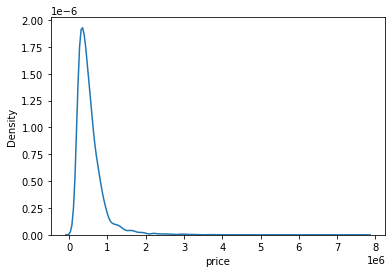

In [ ]:
sns.kdeplot(y)  # Kernel Density Estimation (커널 밀도 추정) 방법은 non-parametric 밀도추정 방법 중 하나로서 커널함수(kernel function)를 이용하여 히스토그램 방법의 문제점을 개선한 방법이다.
plt.show()      # 가격 데이터의 분포도 확인

In [ ]:
y = np.log1p(y)  # price가 왼쪽으로 치우쳐 있으므로 로그 변환
y 

0        12.309987
1        12.100718
2        13.142168
3        12.458779
4        12.583999
           ...    
15030    13.322338
15031    13.822984
15032    12.793862
15033    12.899222
15034    12.691584
Name: price, Length: 15035, dtype: float64

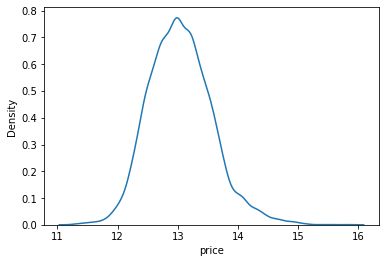

In [ ]:
sns.kdeplot(y)  # 로그변환 후 분포도 확인
plt.show()

In [ ]:
train.info()  # 전체 데이터의 자료형 확인

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15035 entries, 0 to 15034
Data columns (total 19 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   date           15035 non-null  int64  
 1   bedrooms       15035 non-null  int64  
 2   bathrooms      15035 non-null  float64
 3   sqft_living    15035 non-null  int64  
 4   sqft_lot       15035 non-null  int64  
 5   floors         15035 non-null  float64
 6   waterfront     15035 non-null  int64  
 7   view           15035 non-null  int64  
 8   condition      15035 non-null  int64  
 9   grade          15035 non-null  int64  
 10  sqft_above     15035 non-null  int64  
 11  sqft_basement  15035 non-null  int64  
 12  yr_built       15035 non-null  int64  
 13  yr_renovated   15035 non-null  int64  
 14  zipcode        15035 non-null  int64  
 15  lat            15035 non-null  float64
 16  long           15035 non-null  float64
 17  sqft_living15  15035 non-null  int64  
 18  sqft_l

In [ ]:
from sklearn.model_selection import train_test_split  #RMSE 점수 계산을 위해 라이브러리 불러오기
from sklearn.metrics import mean_squared_error

In [ ]:
def rmse(y_test, y_pred):
    return np.sqrt(mean_squared_error(np.expm1(y_test),np.expm1(y_pred)))  # exp로 변환 후 MSE를 계산한 값에 제곱근을 취하여 RMSE 구하기

In [ ]:
# XGBRegressor, LGB<Regressor, GradientBoostingRegressor, RandomForestRegressor 네 가지 모델 불러오기
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import RandomForestRegressor

In [ ]:
random_state=2020  # random state를 고정값을 준다.

gboost = GradientBoostingRegressor(random_state=random_state)
xgboost = XGBRegressor(random_state=random_state)
lightgbm = LGBMRegressor(random_state=random_state)
rdforest = RandomForestRegressor(random_state=random_state)

models = [gboost, xgboost, lightgbm, rdforest]


In [ ]:
gboost.__class__.__name__  # 클래스의 __name__속성 접근

'GradientBoostingRegressor'

In [ ]:
# 네 가지 모델에 대한 RMSE값 구하기
df = {}

for model in models:
    # 모델 이름 획득
    model_name = model.__class__.__name__
    
    # train, test 데이터셋 분리 - 여기에도 random_State 고정
    X_train, X_test, y_train, y_test = train_test_split(train, y, random_state=random_state, test_size=0.2)

    # 모델 학습
    model.fit(X_train, y_train)

    # 예측
    y_pred = model.predict(X_test)

    # 예측 결과의 rmse값 저장
    df[model_name] = rmse(y_test, y_pred)

    # data frame에 저장
    score_df = pd.DataFrame(df, index=['RMSE']).T.sort_values('RMSE', ascending=False)  # 내림차순 정렬
df

[12:15:00] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


{'GradientBoostingRegressor': 128360.19649691365,
 'LGBMRegressor': 111920.36735892233,
 'RandomForestRegressor': 125487.07102453562,
 'XGBRegressor': 131067.44622809246}

In [ ]:
# 위의 과정을 함수로 만들기
def get_scores(models, train, y):
    df = {}

    for model in models:
        model_name = model.__class__.__name__

        X_train, X_test, y_train, y_test = train_test_split(train, y, random_state=random_state, test_size=0.2)
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)

        df[model_name] = rmse(y_test, y_pred)
        score_df = pd.DataFrame(df, index=['RMSE']).T.sort_values('RMSE', ascending=False)

    return score_df

In [ ]:
from sklearn.model_selection import GridSearchCV
# GridSearchCV는 머신러닝에서 모델의 성능향상을 위해 쓰이는 기법중 하나이다.
# 사용자가 직접 모델의 하이퍼 파라미터의 값을 리스트로 입력하면 값에 대한 경우의 수마다 예측 성능을 측정 평가하여 비교하면서 최적의 하이퍼 파라미터 값을 찾는 과정을 진행이다.

In [ ]:
# xgboost 관련 하이퍼 파라미터를 넣어서 준비
param_grid = {
    'n_estimators': [100,300,500,700,1000],
    'max_depth': [1,10],
}

In [ ]:
# lgbm 모델 사용
model = LGBMRegressor(random_state=random_state)

In [ ]:
grid_model = GridSearchCV(model, param_grid=param_grid, \
                          scoring='neg_mean_squared_error', \
                          cv=5, verbose=1, n_jobs=5)

grid_model.fit(train, y)

# param_grid : 탐색할 파라미터의 종류 (딕셔너리로 입력)
# scoring : 모델의 성능을 평가할 지표
# cv : cross validation을 수행하기 위해 train 데이터셋을 나누는 조각의 개수
# verbose : 그리드 탐색을 진행하면서 진행 과정을 출력해서 보여줄 메세지의 양 (숫자가 클수록 더 많은 메세지를 출력합니다.)
# n_jobs : 그리드 탐색을 진행하면서 사용할 CPU의 개수

Fitting 5 folds for each of 10 candidates, totalling 50 fits


GridSearchCV(cv=5, estimator=LGBMRegressor(random_state=2020), n_jobs=5,
             param_grid={'max_depth': [1, 10],
                         'n_estimators': [100, 300, 500, 700, 1000]},
             scoring='neg_mean_squared_error', verbose=1)

In [ ]:
grid_model.cv_results_  # 실험에 대한 결과 저장

{'mean_fit_time': array([0.37045951, 0.75496278, 1.15030727, 1.53617053, 2.16535478,
        1.47611227, 3.34757628, 5.38319788, 7.17798061, 9.94374876]),
 'mean_score_time': array([0.03496408, 0.07994127, 0.1302146 , 0.19066796, 0.25535712,
        0.10537639, 0.28181663, 0.43438616, 0.62820854, 0.8386107 ]),
 'mean_test_score': array([-0.05502043, -0.04202811, -0.0390486 , -0.03772243, -0.03651692,
        -0.02702714, -0.02612748, -0.02624516, -0.02645432, -0.02673912]),
 'param_max_depth': masked_array(data=[1, 1, 1, 1, 1, 10, 10, 10, 10, 10],
              mask=[False, False, False, False, False, False, False, False,
                    False, False],
        fill_value='?',
             dtype=object),
 'param_n_estimators': masked_array(data=[100, 300, 500, 700, 1000, 100, 300, 500, 700, 1000],
              mask=[False, False, False, False, False, False, False, False,
                    False, False],
        fill_value='?',
             dtype=object),
 'params': [{'max_depth':

In [ ]:
params = grid_model.cv_results_['params']  # 파라미터 조합이 저장되어 있는 params 빼내기
params

[{'max_depth': 1, 'n_estimators': 100},
 {'max_depth': 1, 'n_estimators': 300},
 {'max_depth': 1, 'n_estimators': 500},
 {'max_depth': 1, 'n_estimators': 700},
 {'max_depth': 1, 'n_estimators': 1000},
 {'max_depth': 10, 'n_estimators': 100},
 {'max_depth': 10, 'n_estimators': 300},
 {'max_depth': 10, 'n_estimators': 500},
 {'max_depth': 10, 'n_estimators': 700},
 {'max_depth': 10, 'n_estimators': 1000}]

In [ ]:
score = grid_model.cv_results_['mean_test_score']  # 테스트 점수가 저장되어 있는 mean_test_score 빼내기
score

array([-0.05502043, -0.04202811, -0.0390486 , -0.03772243, -0.03651692,
       -0.02702714, -0.02612748, -0.02624516, -0.02645432, -0.02673912])

In [ ]:
#  데이터 프레임 출력
results = pd.DataFrame(params)
results['score'] = score

results

,max_depth,n_estimators,score
0,1,100,-0.055020
1,1,300,-0.042028
2,1,500,-0.039049
3,1,700,-0.037722
4,1,1000,-0.036517
5,10,100,-0.027027
6,10,300,-0.026127
7,10,500,-0.026245
8,10,700,-0.026454
9,10,1000,-0.026739


In [ ]:
# RMASE 점수로 바꾸기
results['RMSE'] = np.sqrt(-1 * results['score'])
results

,max_depth,n_estimators,score,RMSE
0,1,100,-0.055020,0.234564
1,1,300,-0.042028,0.205008
2,1,500,-0.039049,0.197607
3,1,700,-0.037722,0.194223
4,1,1000,-0.036517,0.191094
5,10,100,-0.027027,0.164399
6,10,300,-0.026127,0.161640
7,10,500,-0.026245,0.162004
8,10,700,-0.026454,0.162648
9,10,1000,-0.026739,0.163521


In [ ]:
# 데이터 프레임에 나타난 값은 RMSLE이므로 컬럼의 이름을 RMLSE로 바꾸기
results = results.rename(columns={'RMSE': 'RMSLE'})
results

,max_depth,n_estimators,score,RMSLE
0,1,100,-0.055020,0.234564
1,1,300,-0.042028,0.205008
2,1,500,-0.039049,0.197607
3,1,700,-0.037722,0.194223
4,1,1000,-0.036517,0.191094
5,10,100,-0.027027,0.164399
6,10,300,-0.026127,0.161640
7,10,500,-0.026245,0.162004
8,10,700,-0.026454,0.162648
9,10,1000,-0.026739,0.163521


In [ ]:
# RMSLE가 낮은 순서대로 정렬
results = results.sort_values('RMSLE')
results

,max_depth,n_estimators,score,RMSLE
6,10,300,-0.026127,0.161640
7,10,500,-0.026245,0.162004
8,10,700,-0.026454,0.162648
9,10,1000,-0.026739,0.163521
5,10,100,-0.027027,0.164399
4,1,1000,-0.036517,0.191094
3,1,700,-0.037722,0.194223
2,1,500,-0.039049,0.197607
1,1,300,-0.042028,0.205008
0,1,100,-0.055020,0.234564


In [ ]:
# 위 과정을 하나의 함수로 만들기
def my_GridSearch(model, train, y, param_grid, verbose=2, n_jobs=5):
    #GridSearchCV 모델로 초기화
    grid_model = GridSearchCV(model, param_grid=param_grid, scoring='neg_mean_squared_error', \
                              cv=5, verbose=verbose, n_jobs=n_jobs)
    
    # 모델 fitting
    grid_model.fit(train, y)

    # 결과값 저장
    params = grid_model.cv_results_['params']
    score = grid_model.cv_results_['mean_test_score']

    # 데이터 프레임 생성
    results = pd.DataFrame(params)
    results['score'] = score

    # RMSLE 값 계산 후 정렬
    results['RMSLE'] = np.sqrt(-1 * results['score'])
    results = results.sort_values('RMSLE')

    return results

In [ ]:
# 그리드 탐색
param_grid = {
    'n_estimators': [50,100],
    'max_depth': [1,10],
}

model = LGBMRegressor(random_state=random_state)
my_GridSearch(model, train, y, param_grid, verbose=2, n_jobs=5)

# 가장 좋은 조합은 max_depth = 10, n_estimators =100

Fitting 5 folds for each of 4 candidates, totalling 20 fits


,max_depth,n_estimators,score,RMSLE
3,10,100,-0.027027,0.164399
2,10,50,-0.029177,0.170814
1,1,100,-0.055020,0.234564
0,1,50,-0.073394,0.270914


In [ ]:
# 해당 파라미터로 구성된 모델 준비, 학습 후 예측 결과 생성
model = LGBMRegressor(max_depth=10, n_estimators=1000, random_state=random_state)
model.fit(train, y)
prediction = model.predict(test)
prediction

array([13.19495169, 13.11873096, 14.01893003, ..., 13.05179856,
       12.72122862, 13.00310932])

In [ ]:
# 지수변환
prediction = np.expm1(prediction)
prediction

array([ 537642.88051594,  498186.08760612, 1225585.45639546, ...,
        465932.667101  ,  334778.91334668,  443790.13608839])

In [ ]:
# sample_submission.csv 파일 가져오기
data_dir = '/content/drive/MyDrive/colab/data'

submission_path = join(data_dir, 'sample_submission.csv')
submission = pd.read_csv(submission_path)
submission.head()

,id,price
0,15035,100000
1,15036,100000
2,15037,100000
3,15038,100000
4,15039,100000


In [ ]:
# 위의 데이터프레임에 예측한 값을 덮어씌우기
submission['price'] = prediction
submission.head()

,id,price
0,15035,5.376429e+05
1,15036,4.981861e+05
2,15037,1.225585e+06
3,15038,2.809225e+05
4,15039,3.260536e+05


In [ ]:
# 위의 데이터를 csv 파일로 저장
# RMSLE 값 넣어주기
submission_csv_path = '{}/submission_{}_RMSLE_{}.csv'.format(data_dir, 'lgbm', '0.164399')
submission.to_csv(submission_csv_path, index=False)
print(submission_csv_path)

/content/drive/MyDrive/colab/data/submission_lgbm_RMSLE_0.164399.csv


In [ ]:
# 위의 과정을 하나의 함수로 정리하기 
def save_submission(model, train, y, test, model_name, rmsle=None):
    model.fit(train, y)
    prediction = model.predict(test)
    prediction = np.expm1(prediction)
    data_dir = '/content/drive/MyDrive/colab/data'
    submission_path = join(data_dir, 'sample_submission.csv')
    submission['price'] = prediction
    submission_csv_path = '{}/submission_{}_RMSLE{}.csv'.format(data_dir, model_name, rmsle)
    submission.to_csv(submission_csv_path, index=False)
    print('{} saved!'.format(submission_csv_path))

In [ ]:
save_submission(model, train, y, test, 'lgbm', rmsle='0.0168')

/content/drive/MyDrive/colab/data/submission_lgbm_RMSLE0.0168.csv saved!


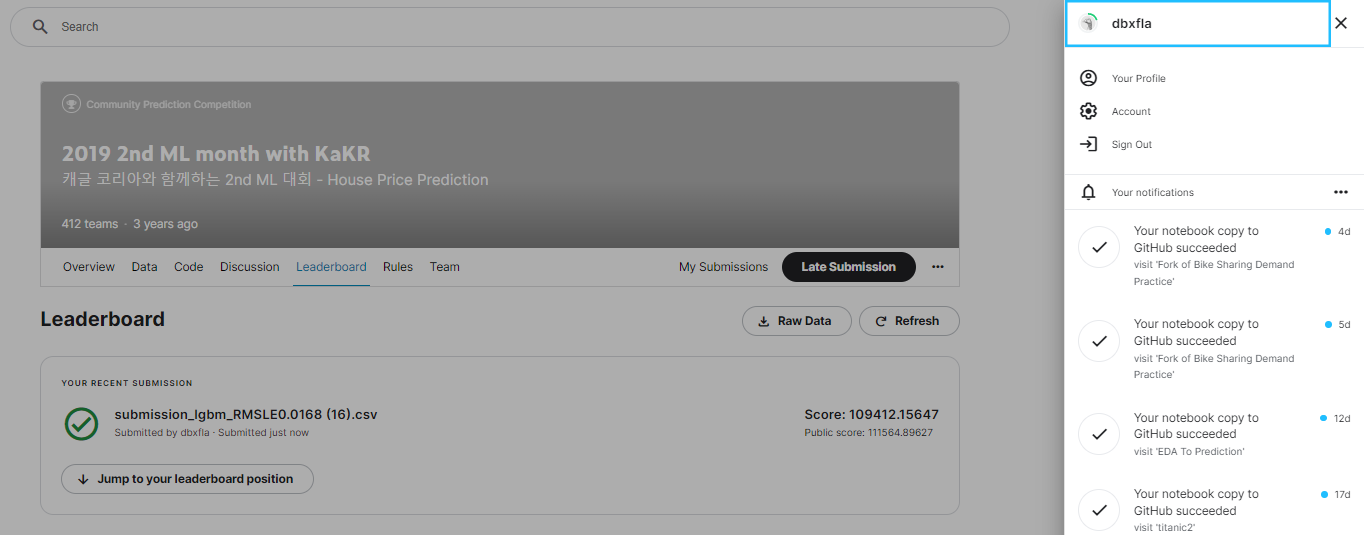

**✍ 회고**

* 이번 프로젝트는 하이퍼 파라미터를 튜닝하면 Priavte score 기준 110000 이하의 점수를 얻어야 한다. 하지만 하이퍼 파라미터를 계속해서 바꾸고 업로드해도 score가 115807.04439만 나왔다. 알고보니 학습을 시킨 후 그 값을 예측 결과에 넣어주지 않았었다. 더 넓은 시야에서 문제를 바라보는 자세를 가져야겠다.

* 빅데이터를 인공지능에 입력한다고 해서 즉각적으로 원하는 결과를 얻는 것이 아니라, 개발자의 손을 어느 정도 거쳐야 제대로 된 모델을 설계할 수 있다는 생각이 들었다.

* 직접 하이퍼 파라미터를 조정하면서, 처음으로 캐글 대회에 파일을 업로드하고 score도 매겨보았다. 다양한 방법들을 시도해본 것은 아니지만 예전보다 조금 성장한 것 같았다.